In [ ]:
import os
import glob
from pathlib import Path
import yaml

import logging

import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.model_selection import train_test_split, KFold

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


# Custom Utilities Module
from utils.paths import get_paths
from utils.file_io import load_data


# Show more columns
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 200)

# Initiate Logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [ ]:
# Get Path's Object
paths = get_paths()

logger.info(f"Project Root Path Loaded: {paths.root}")
  
logger.info(f"Project Data Path Loaded: {paths.data}")

logger.info(f"Data Bronze Path Loaded: {paths.data_bronze}")
logger.info(f"Data Silver Path Loaded: {paths.data_silver}")

INFO:__main__:Project Root Path Loaded: /workspace
INFO:__main__:Project Data Path Loaded: /workspace/data
INFO:__main__:Data Raw Path Loaded: /workspace/data/raw
INFO:__main__:Data Bronze Path Loaded: /workspace/data/bronze
INFO:__main__:Data Silver Path Loaded: /workspace/data/silver


In [ ]:
# Load Data

data = load_data(paths.data_bronze, "pump_bronze.csv")

INFO:utils.file_io:Loading CSV file: /workspace/data/raw/pump_sensor_data/sensor.csv
INFO:utils.file_io:Loaded CSV: sensor.csv | shape=(220320, 55) | columns=['Unnamed: 0', 'timestamp', 'sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30', 'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35', 'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40', 'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45', 'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49', 'sensor_50', 'sensor_51', 'machine_status']


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 55 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      220320 non-null  int64  
 1   timestamp       220320 non-null  object 
 2   sensor_00       210112 non-null  float64
 3   sensor_01       219951 non-null  float64
 4   sensor_02       220301 non-null  float64
 5   sensor_03       220301 non-null  float64
 6   sensor_04       220301 non-null  float64
 7   sensor_05       220301 non-null  float64
 8   sensor_06       215522 non-null  float64
 9   sensor_07       214869 non-null  float64
 10  sensor_08       215213 non-null  float64
 11  sensor_09       215725 non-null  float64
 12  sensor_10       220301 non-null  float64
 13  sensor_11       220301 non-null  float64
 14  sensor_12       220301 non-null  float64
 15  sensor_13       220301 non-null  float64
 16  sensor_14       220299 non-null  float64
 17  sensor_15 

In [7]:
data.head(25)

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.21180,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,NaN,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.989580,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.21180,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,NaN,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.989580,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.21180,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,37.86777,48.17723,32.08894,1.708474,420.8480,NaN,462.7798,459.6364,2.500062,666.2234,399.9418,880.4237,501.3617,982.7342,631.1326,740.8031,849.8997,454.2390,778.5734,715.6266,661.5740,721.8750,694.7721,441.2635,169.9820,343.1955,200.9694,93.90508,41.40625,31.25000,69.53125,30.468750,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.16840,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,38.57977,48.65607,31.67221,1.579427,420.7494,NaN,462.8980,460.8858,2.509521,666.0114,399.1046,878.8917,499.0430,977.7520,625.4076,739.2722,847.7579,474.8731,779.5091,690.4011,686.1111,754.6875,683.3831,446.2493,166.4987,343.9586,193.1689,101.04060,41.92708,31.51042,72.13541,30.468750,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.21180,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,39.48939,49.06298,31.95202,1.683831,419.8926,NaN,461.4906,468.2206,2.604785,663.2111,400.5426,882.5874,498.5383,979.5755,627.1830,737.6033,846.9182,408.8159,785.2307,704.6937,631.4814,766.1458,702.4431,433.9081,164.7498,339.9630,193.8770,101.70380,42.70833,31.51042,76.82291,30.989580,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL
5,5,2018-04-01 00:05:00,2.453588,47.09201,53.16840,46.397568,637.6157,78.18568,13.41146,16.16753,15.89265,15.16204,39.29406,49.37051,32.23816,1.673484,418.9049,NaN,461.8948,461.9289,2.507935,663.4962,398.6428,872.4973,498.4064,974.6847,624.3462,739.2036,846.4617,429.6945,777.2820,700.7193,623.1481,734.3750,711.2128,438.6517,162.8758,333.7975,196.4579,90.84048,42.70833,31.77083,79.94791,30.989580,31.250000,42.70833,38.773150,63.65741,51.79398,38.773150,164.6412,66.55093,241.6088,201.6782,NORMAL
6,6,2018-04-01 00:06:00,2.455556,47.04861,53.16840,46.397568,633.3333,75.81614,13.43316,16.13136,15.65393,15.08247,38.29974,49.57146,32.00982,1.684984,420.3324,NaN,464.2402,467.5146,2.598702,667.4751,401.1847,882.7164,500.4944,981.2908,631.2756,740.9517,853.9647,458.3623,771.8188,722.5254,674.0740,707.8125,716.1951,433.5065,161.9678,330.3747,194.0652,89.23161,42.70833,32.29166,79.94791,31.250000,31.510420,43.22916,38.194440,61.92130,51.79398,3

In [9]:
# Basic Dataframe Information/Summary

print("Shape:", data.shape)
print("\nData types:")
print(data.dtypes)

print("\nMemory usage (MB):")
print(data.memory_usage(deep=True).sum() / (1024 ** 2))

print("\nFirst 5 rows:")
display(data.head())

print("\nBasic numeric summary:")
display(data.describe().T)

print("\nBasic object / categorical summary:")
display(data.describe(include="object").T)

Shape: (220320, 55)

Data types:
Unnamed: 0          int64
timestamp          object
sensor_00         float64
sensor_01         float64
sensor_02         float64
sensor_03         float64
sensor_04         float64
sensor_05         float64
sensor_06         float64
sensor_07         float64
sensor_08         float64
sensor_09         float64
sensor_10         float64
sensor_11         float64
sensor_12         float64
sensor_13         float64
sensor_14         float64
sensor_15         float64
sensor_16         float64
sensor_17         float64
sensor_18         float64
sensor_19         float64
sensor_20         float64
sensor_21         float64
sensor_22         float64
sensor_23         float64
sensor_24         float64
sensor_25         float64
sensor_26         float64
sensor_27         float64
sensor_28         float64
sensor_29         float64
sensor_30         float64
sensor_31         float64
sensor_32         float64
sensor_33         float64
sensor_34         float64
senso

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,NaN,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,NaN,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,37.86777,48.17723,32.08894,1.708474,420.8480,NaN,462.7798,459.6364,2.500062,666.2234,399.9418,880.4237,501.3617,982.7342,631.1326,740.8031,849.8997,454.2390,778.5734,715.6266,661.5740,721.8750,694.7721,441.2635,169.9820,343.1955,200.9694,93.90508,41.40625,31.25000,69.53125,30.46875,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,38.57977,48.65607,31.67221,1.579427,420.7494,NaN,462.8980,460.8858,2.509521,666.0114,399.1046,878.8917,499.0430,977.7520,625.4076,739.2722,847.7579,474.8731,779.5091,690.4011,686.1111,754.6875,683.3831,446.2493,166.4987,343.9586,193.1689,101.04060,41.92708,31.51042,72.13541,30.46875,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,39.48939,49.06298,31.95202,1.683831,419.8926,NaN,461.4906,468.2206,2.604785,663.2111,400.5426,882.5874,498.5383,979.5755,627.1830,737.6033,846.9182,408.8159,785.2307,704.6937,631.4814,766.1458,702.4431,433.9081,164.7498,339.9630,193.8770,101.70380,42.70833,31.51042,76.82291,30.98958,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL



Basic numeric summary:


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,220320.0,110159.500000,63601.049991,0.000000,55079.750000,110159.500000,165239.250000,220319.000000
sensor_00,210112.0,2.372221,0.412227,0.000000,2.438831,2.456539,2.499826,2.549016
sensor_01,219951.0,47.591611,3.296666,0.000000,46.310760,48.133678,49.479160,56.727430
sensor_02,220301.0,50.867392,3.666820,33.159720,50.390620,51.649300,52.777770,56.032990
sensor_03,220301.0,43.752481,2.418887,31.640620,42.838539,44.227428,45.312500,48.220490
sensor_04,220301.0,590.673936,144.023912,2.798032,626.620400,632.638916,637.615723,800.000000
sensor_05,220301.0,73.396414,17.298247,0.000000,69.976260,75.576790,80.912150,99.999880
sensor_06,215522.0,13.501537,2.163736,0.014468,13.346350,13.642940,14.539930,22.251160
sensor_07,214869.0,15.843152,2.201155,0.000000,15.907120,16.167530,16.427950,23.596640
sensor_08,215213.0,15.200721,2.037390,0.028935,15.183740,15.494790,15.697340,24.348960



Basic object / categorical summary:


,count,unique,top,freq
timestamp,220320,220320,2018-08-31 23:43:00,1
machine_status,220320,3,NORMAL,205836


In [10]:
unique_counts = data.nunique().sort_values(ascending=False)
display(unique_counts.to_frame("n_unique"))

high_card_cols = unique_counts[unique_counts > 50].index.tolist()
low_card_cols = unique_counts[unique_counts <= 50].index.tolist()

print("High-cardinality columns (>50 uniques):", high_card_cols)
print("Low-cardinality columns (<=50 uniques):", low_card_cols)

,n_unique
Unnamed: 0,220320
timestamp,220320
sensor_32,205414
sensor_34,203895
sensor_27,203198
sensor_29,201908
sensor_35,201781
sensor_36,201437
sensor_33,200855
sensor_10,198804


High-cardinality columns (>50 uniques): ['Unnamed: 0', 'timestamp', 'sensor_32', 'sensor_34', 'sensor_27', 'sensor_29', 'sensor_35', 'sensor_36', 'sensor_33', 'sensor_10', 'sensor_11', 'sensor_13', 'sensor_05', 'sensor_28', 'sensor_37', 'sensor_12', 'sensor_26', 'sensor_25', 'sensor_18', 'sensor_17', 'sensor_24', 'sensor_21', 'sensor_22', 'sensor_23', 'sensor_16', 'sensor_19', 'sensor_14', 'sensor_20', 'sensor_04', 'sensor_31', 'sensor_30', 'sensor_48', 'sensor_00', 'sensor_50', 'sensor_51', 'sensor_39', 'sensor_40', 'sensor_46', 'sensor_01', 'sensor_02', 'sensor_49', 'sensor_06', 'sensor_43', 'sensor_42', 'sensor_45', 'sensor_44', 'sensor_08', 'sensor_47', 'sensor_38', 'sensor_41', 'sensor_03', 'sensor_09', 'sensor_07']
Low-cardinality columns (<=50 uniques): ['machine_status', 'sensor_15']


In [11]:
# Duplicates
n_duplicates = data.duplicated().sum()
print(f"Number of duplicated rows: {n_duplicates}")

# Nulls
null_counts = data.isna().sum()
null_pct = (null_counts / len(data)) * 100
null_df = pd.DataFrame({"null_count": null_counts, "null_pct": null_pct})
null_df = null_df[null_df["null_count"] > 0].sort_values("null_pct", ascending=False)

print("\nColumns with missing values:")
display(null_df)

# Optional: drop full-duplicate rows
if n_duplicates > 0:
    data = data.drop_duplicates().reset_index(drop=True)
    print(f"\nDropped {n_duplicates} duplicate rows. New shape: {data.shape}")



Number of duplicated rows: 0

Columns with missing values:


,null_count,null_pct
sensor_15,220320,100.000000
sensor_50,77017,34.956881
sensor_51,15383,6.982117
sensor_00,10208,4.633261
sensor_07,5451,2.474129
sensor_08,5107,2.317992
sensor_06,4798,2.177741
sensor_09,4595,2.085603
sensor_01,369,0.167484
sensor_30,261,0.118464


Numeric columns: ['Unnamed: 0', 'sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30', 'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35', 'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40', 'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45', 'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49', 'sensor_50', 'sensor_51']
Categorical columns: ['timestamp', 'machine_status']


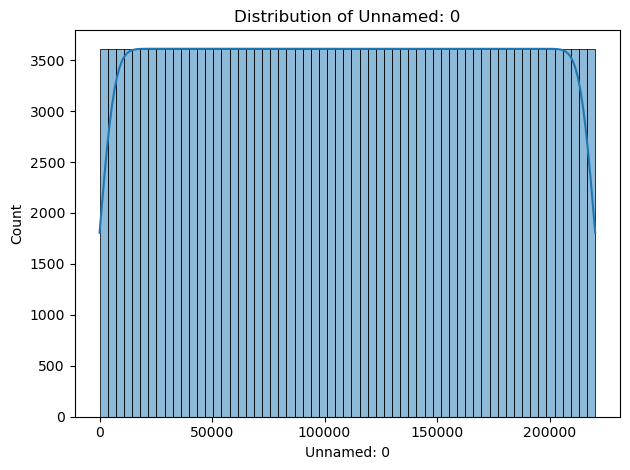

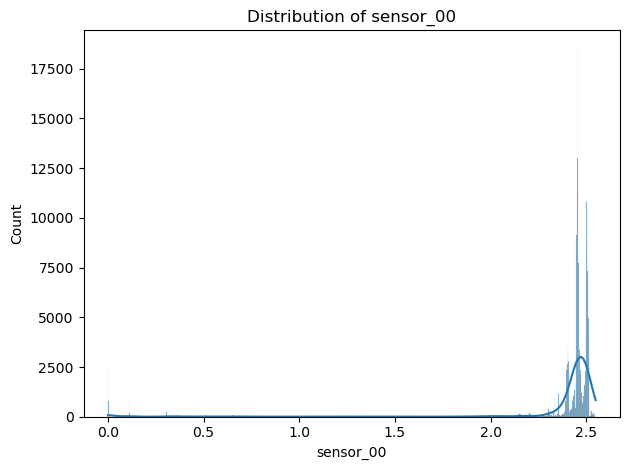

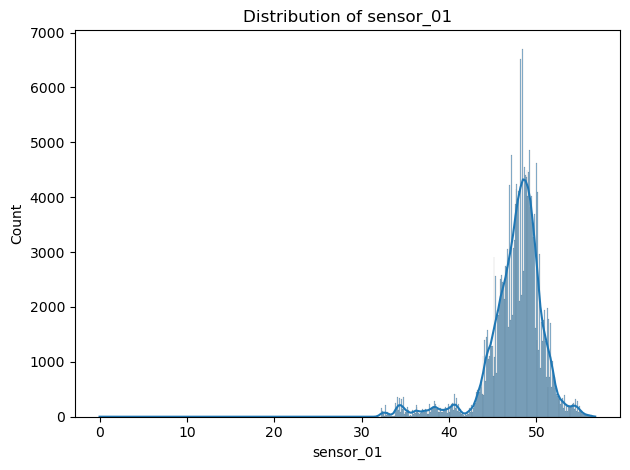

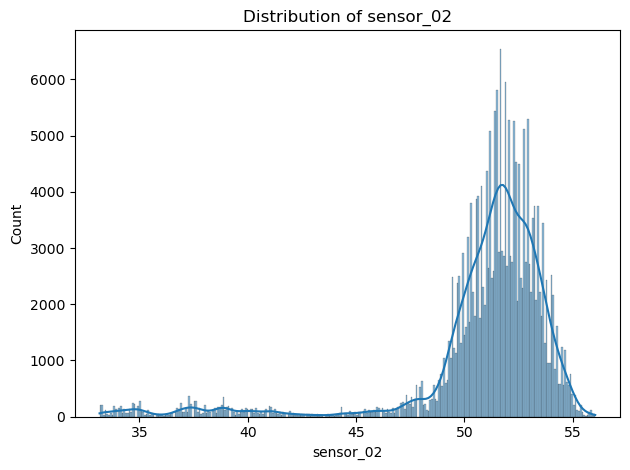

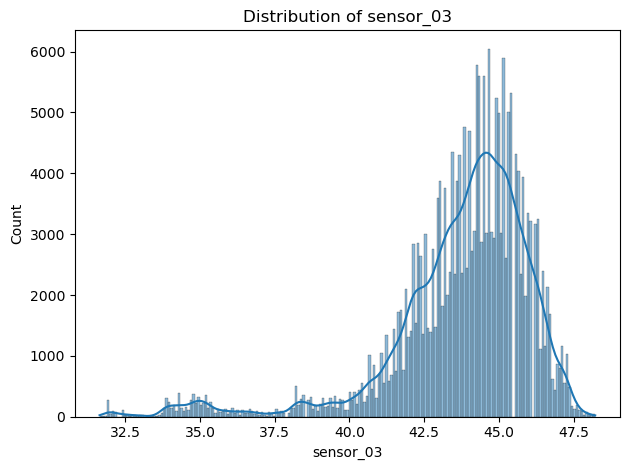

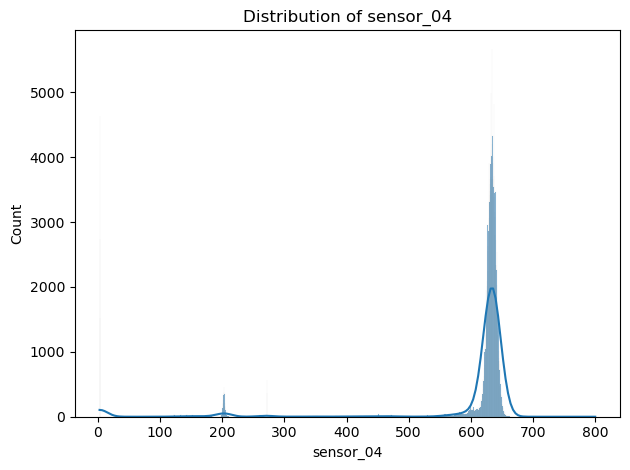

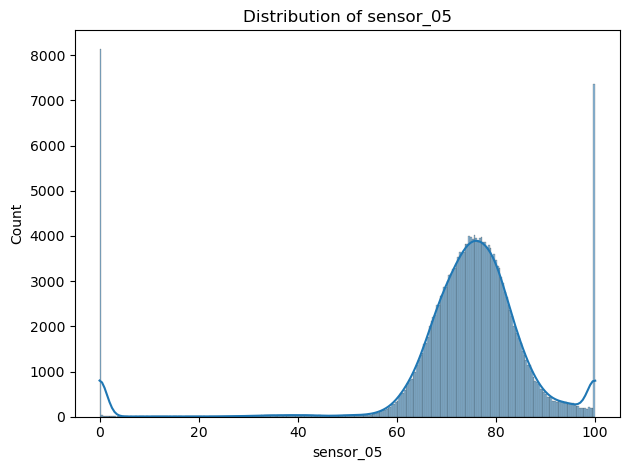

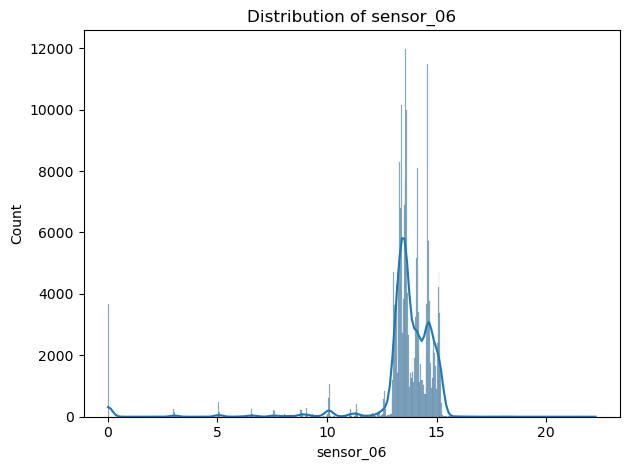

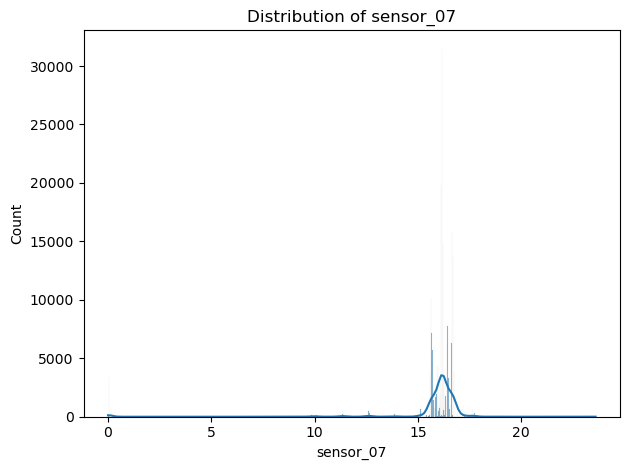

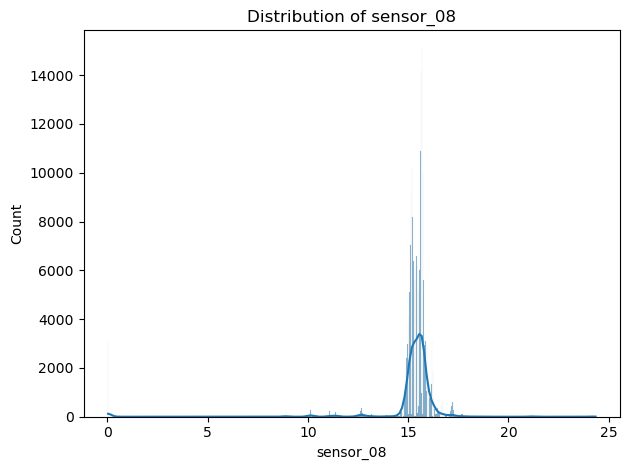

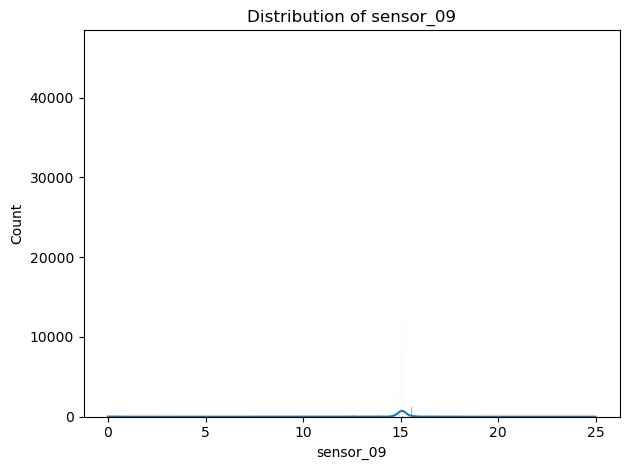

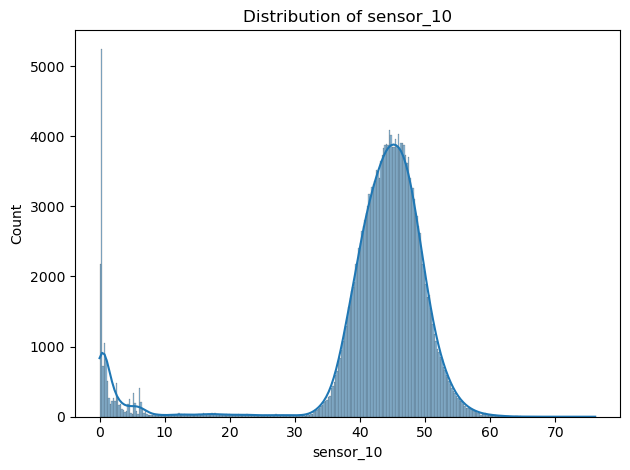

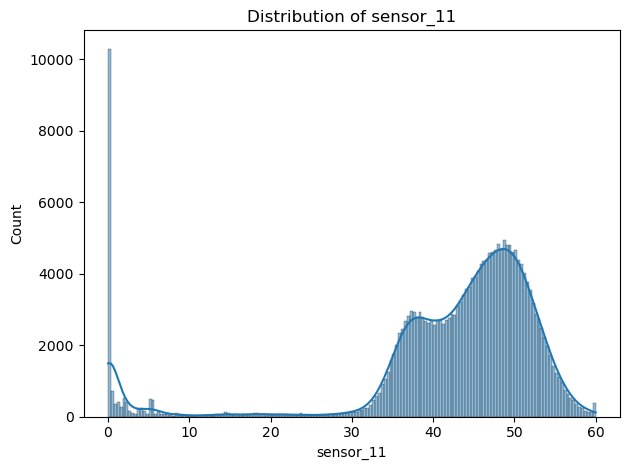

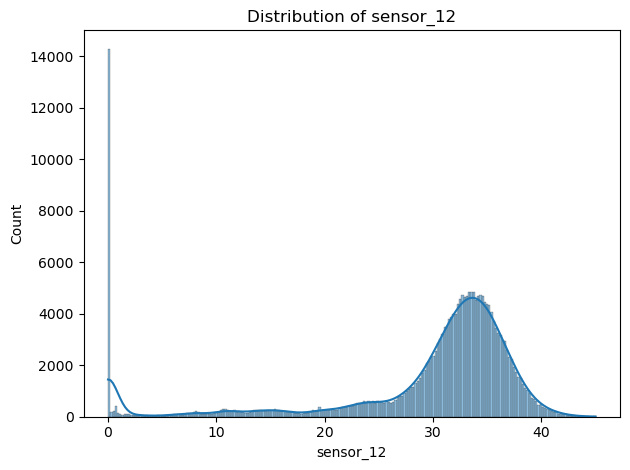

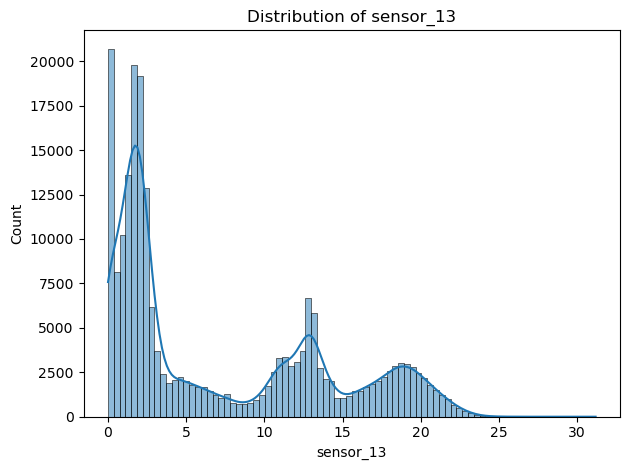

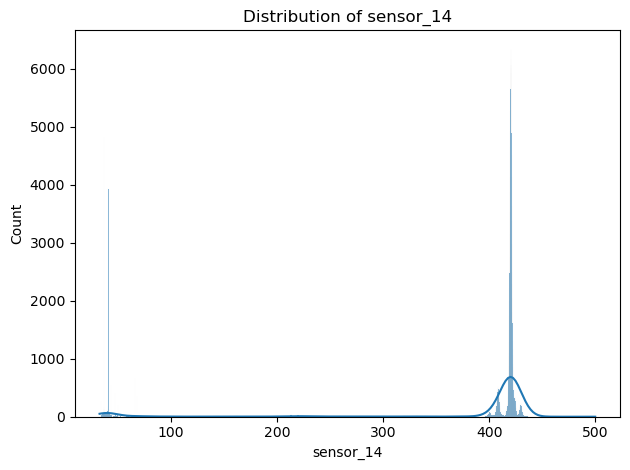

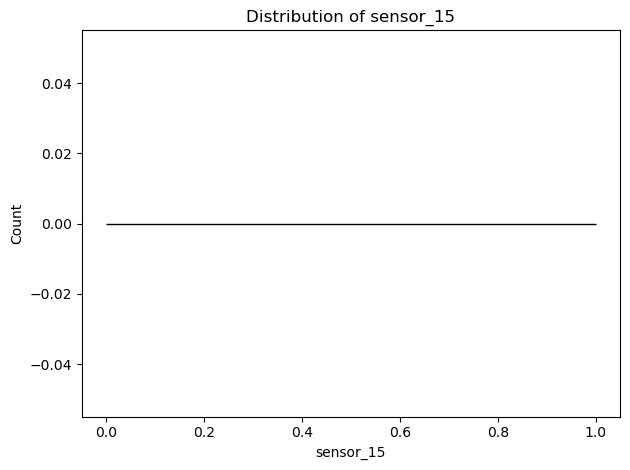

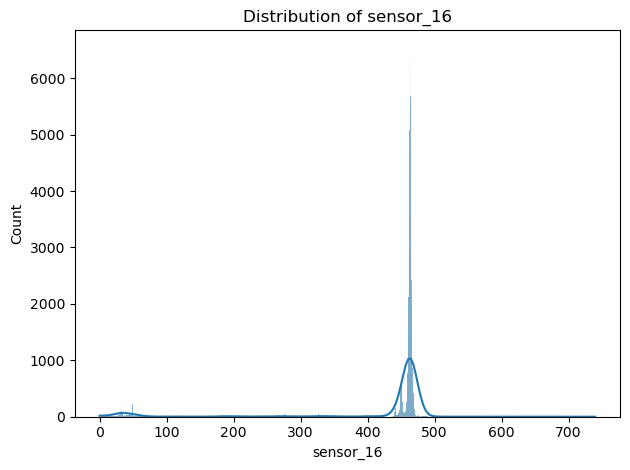

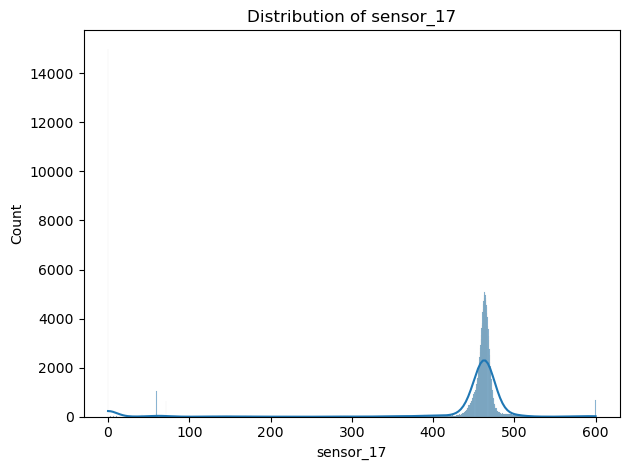

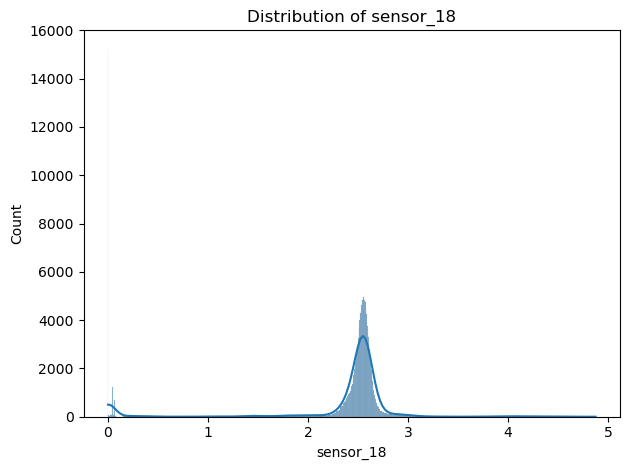

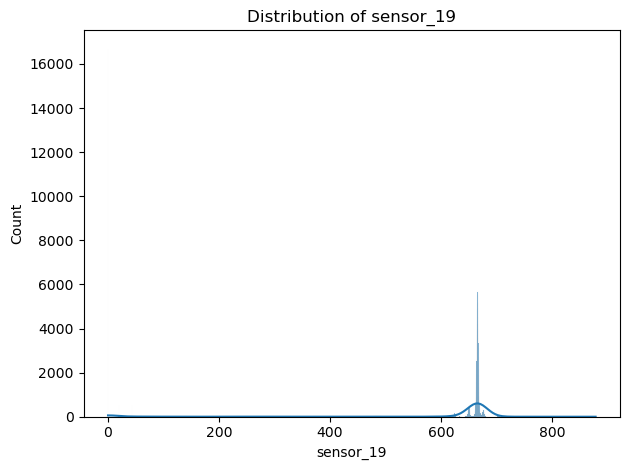

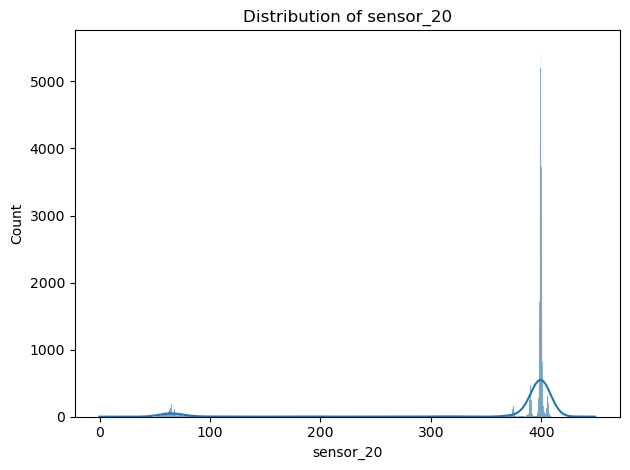

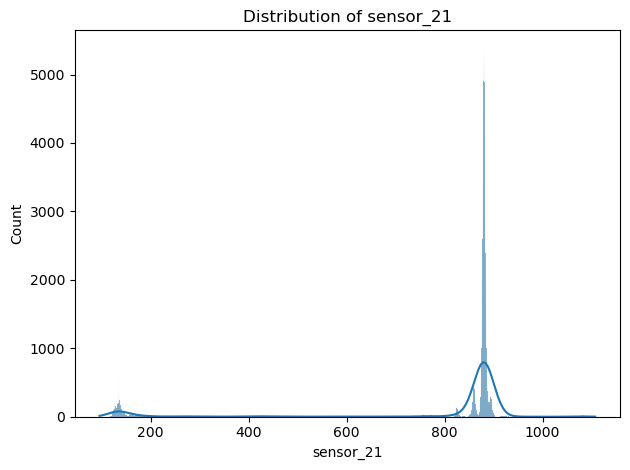

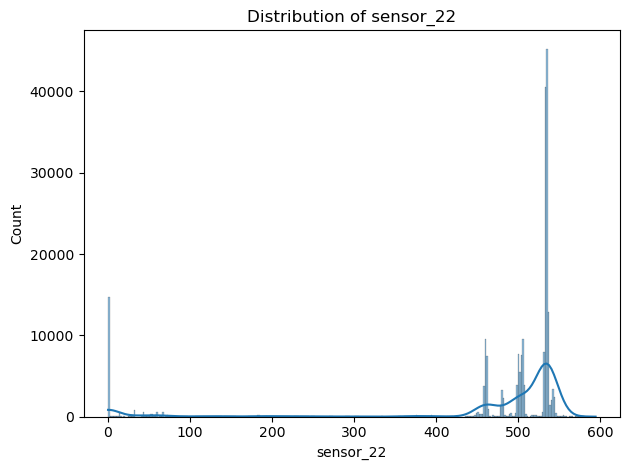

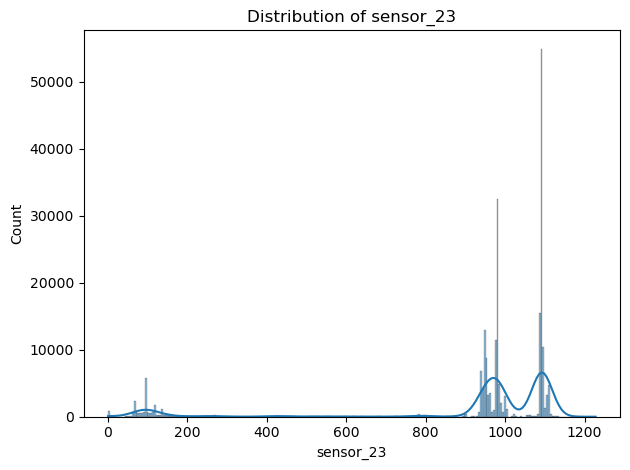

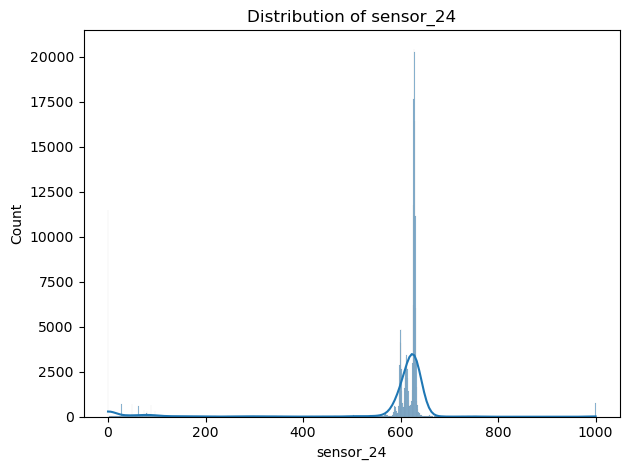

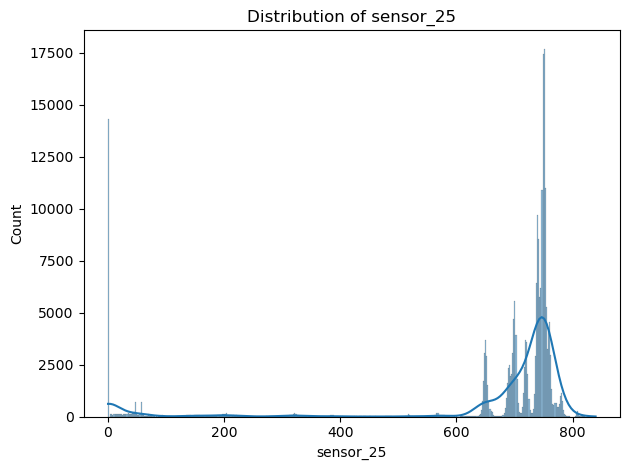

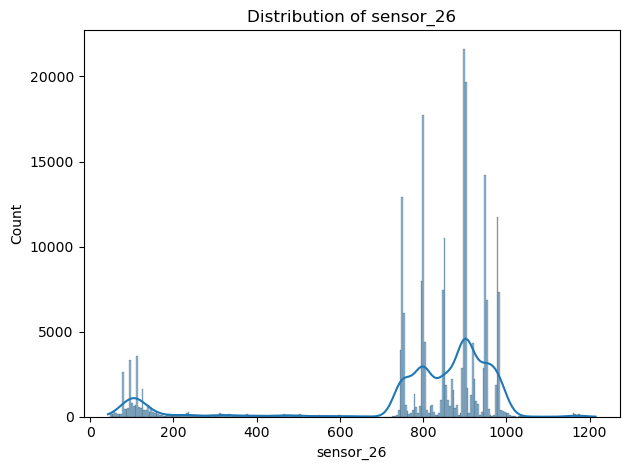

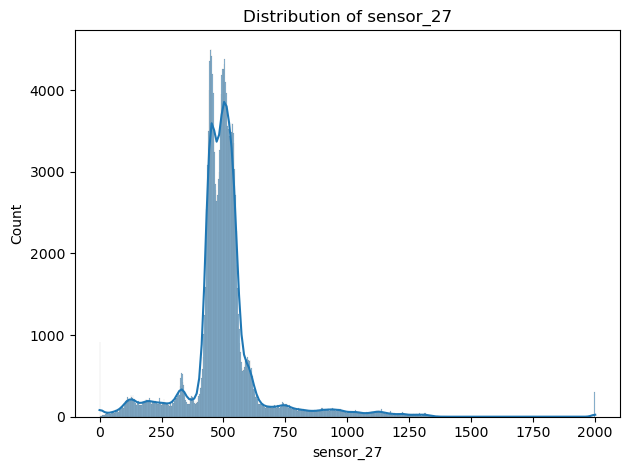

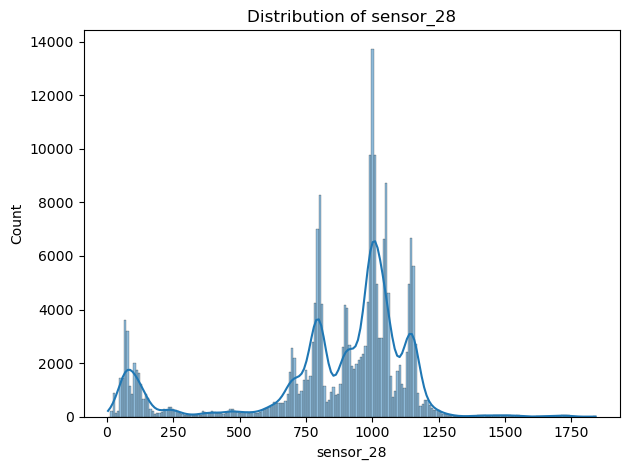

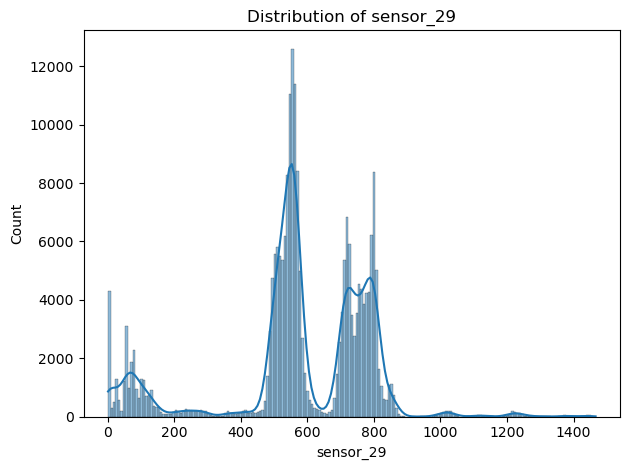

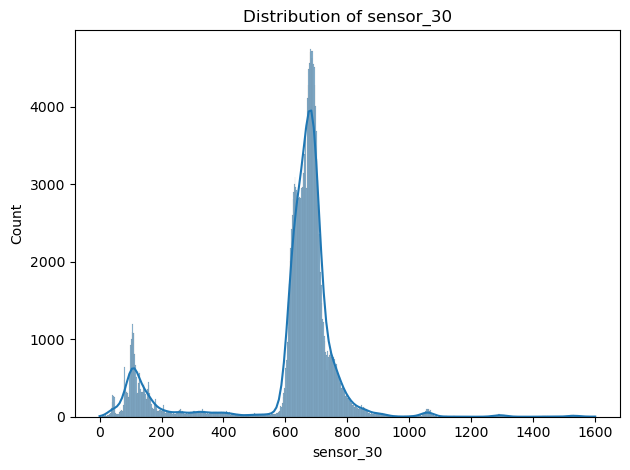

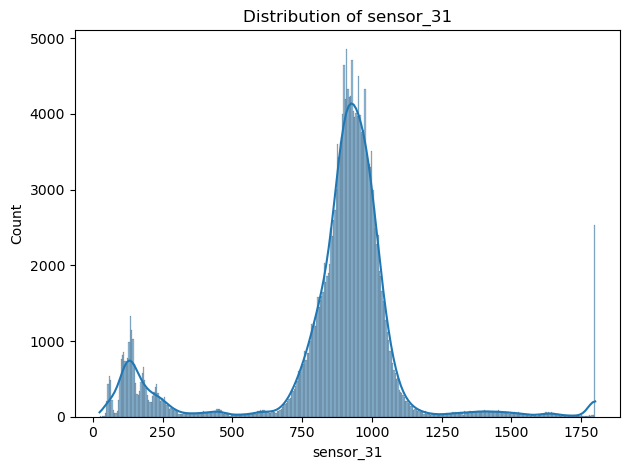

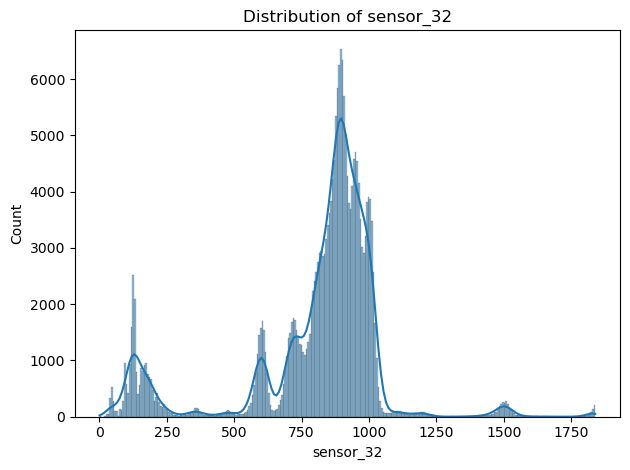

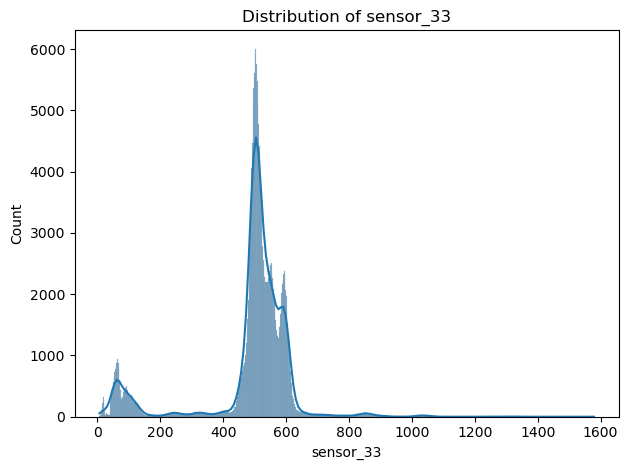

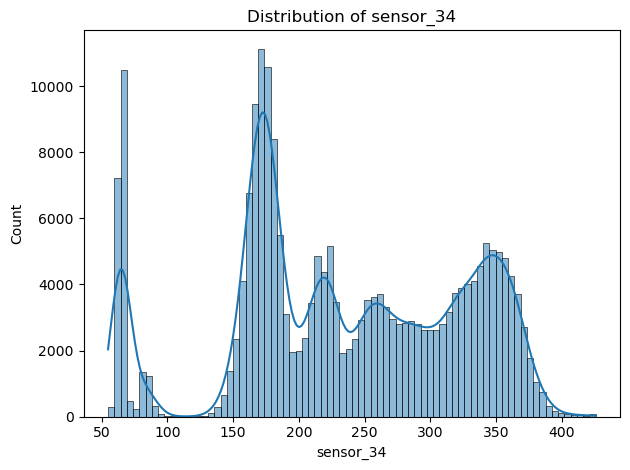

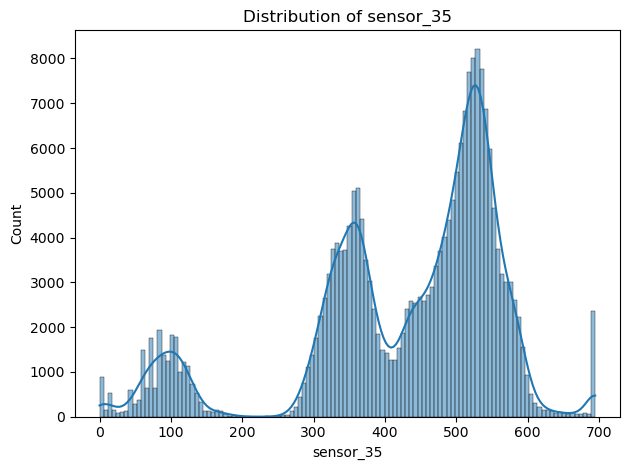

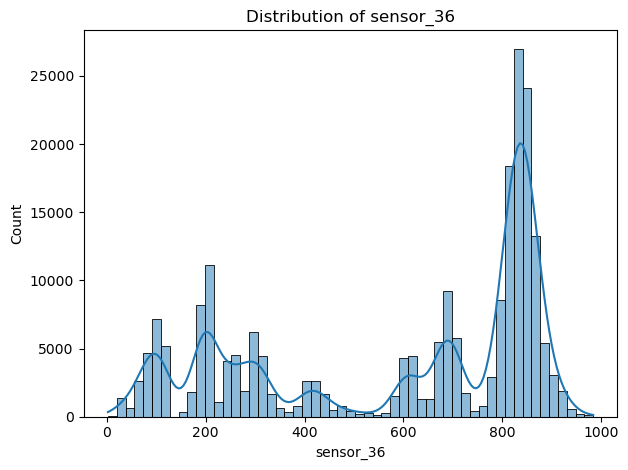

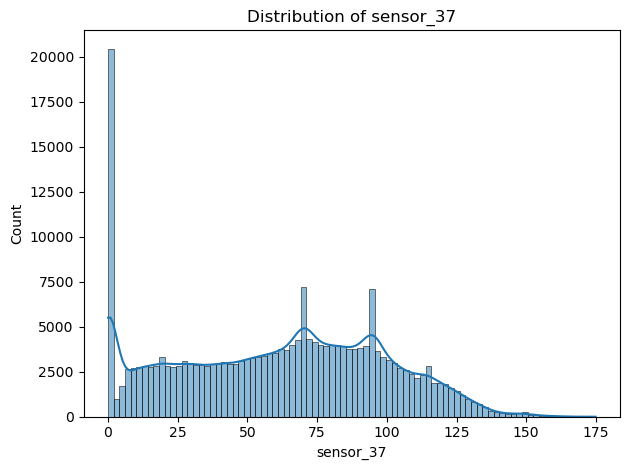

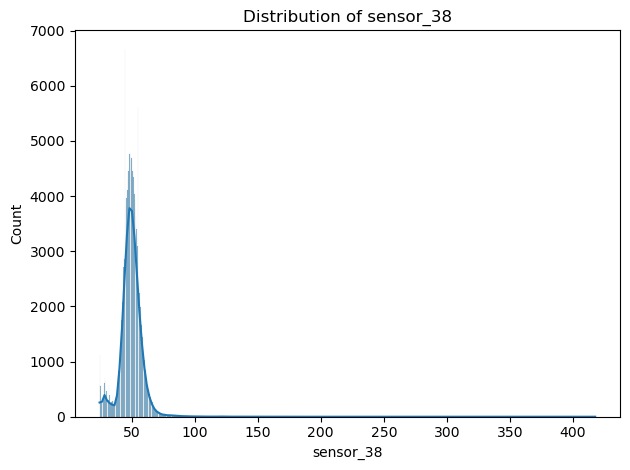

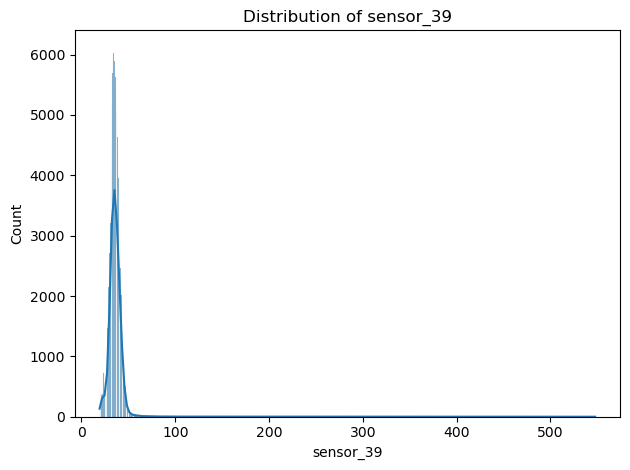

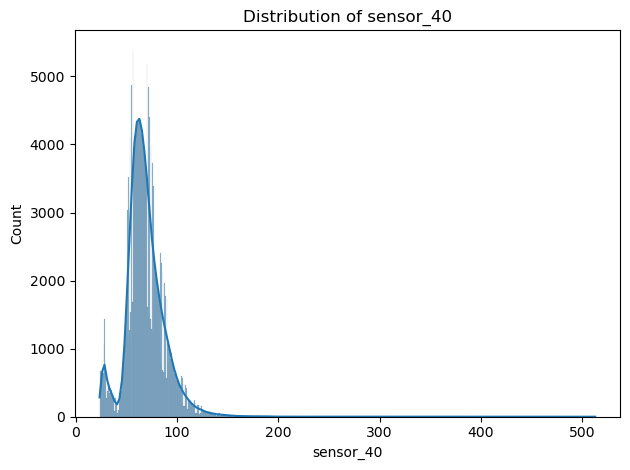

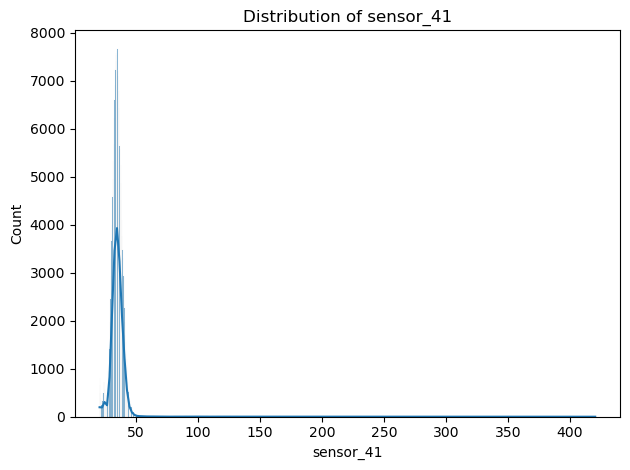

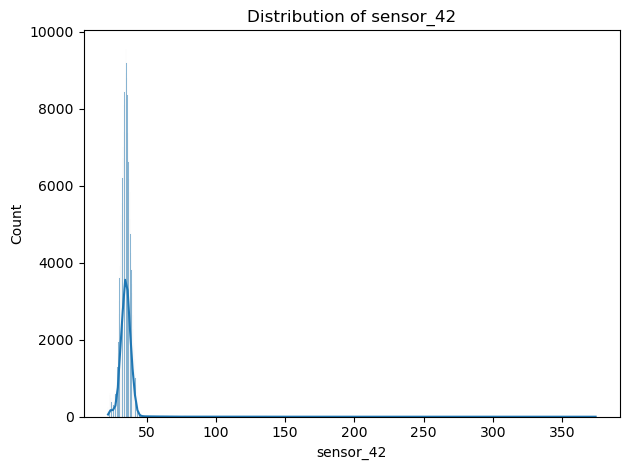

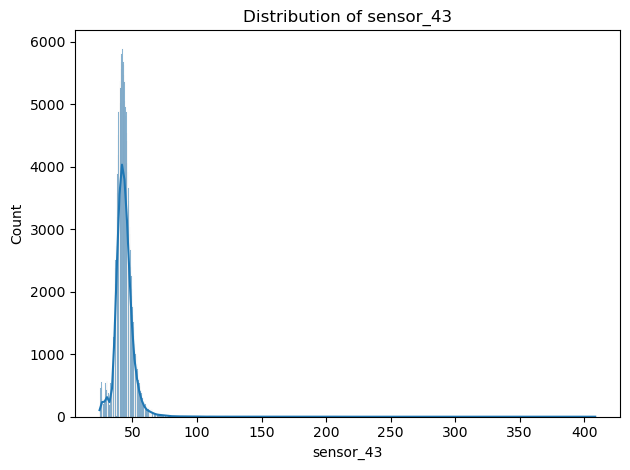

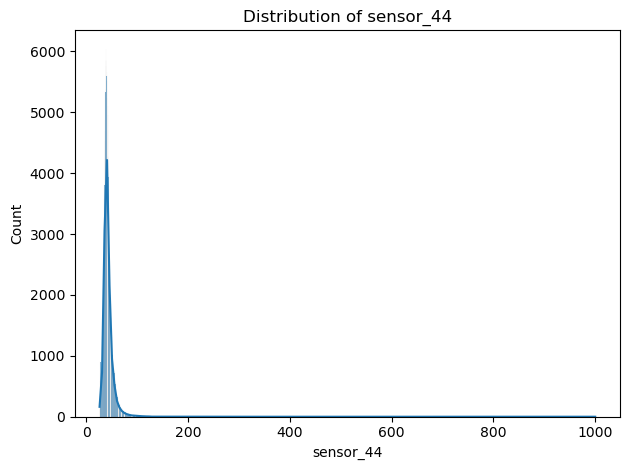

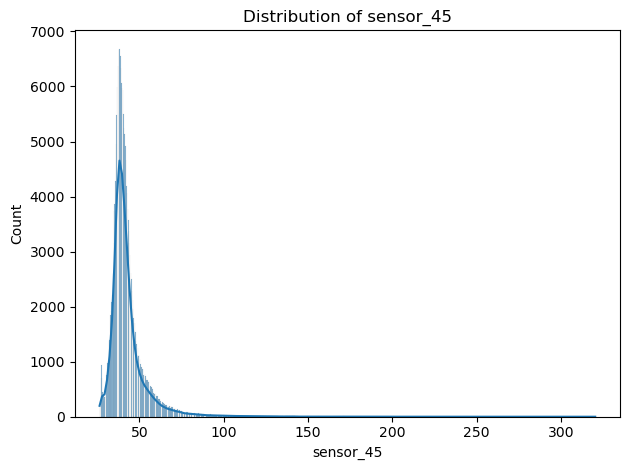

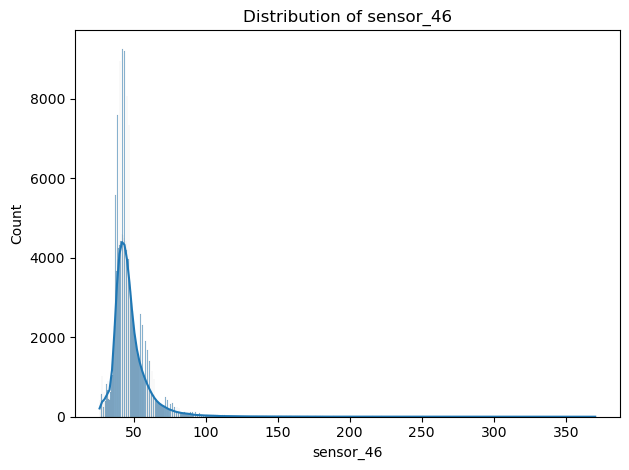

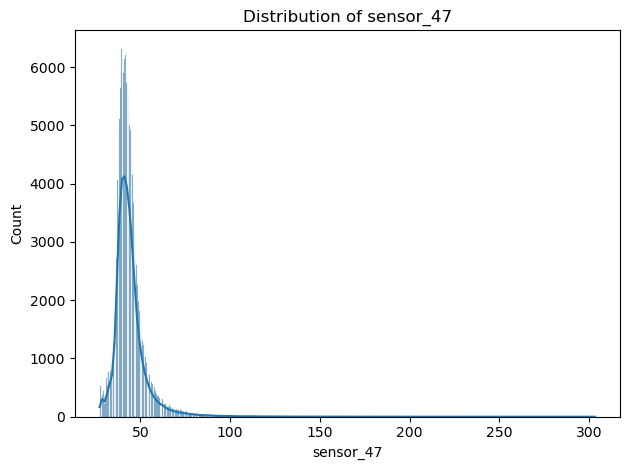

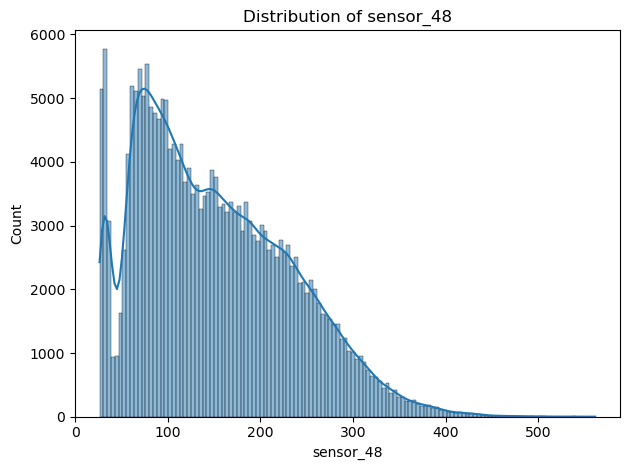

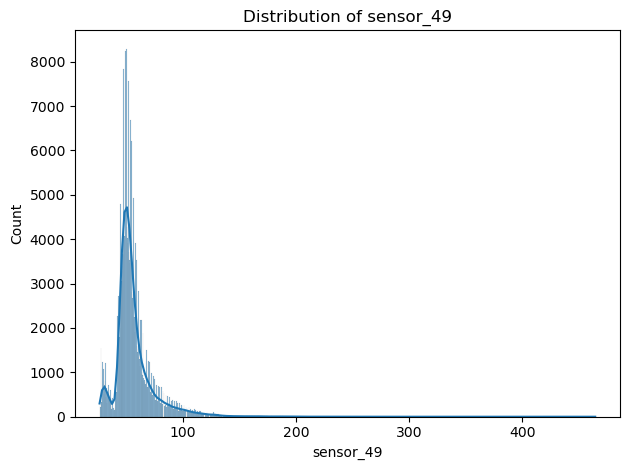

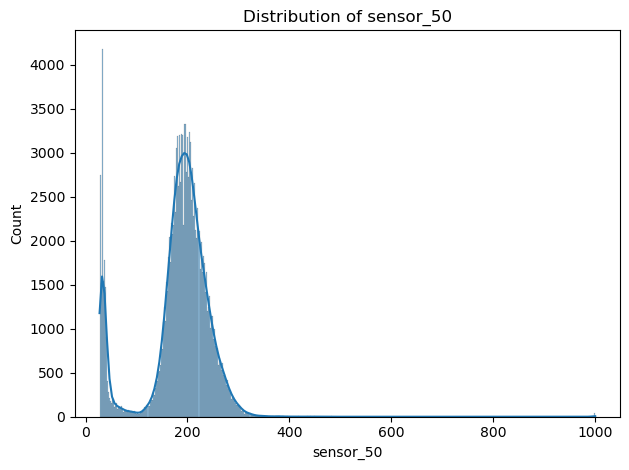

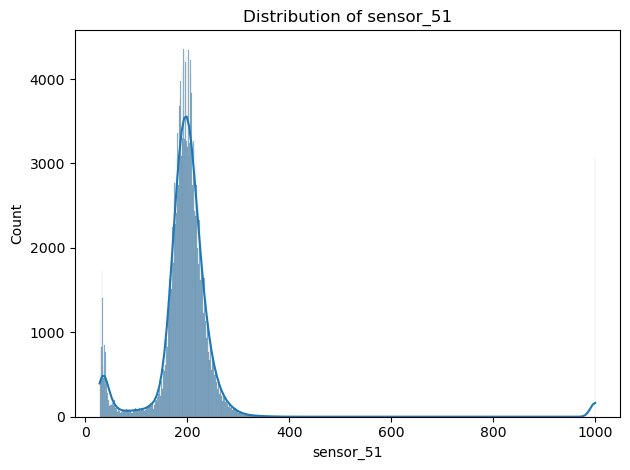

In [12]:
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = data.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

# Histograms for numeric columns
for col in numeric_cols:
    plt.figure()
    sns.histplot(data=data, x=col, kde=True)
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()
